# Data Cleaning


## Import & Load


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load the dataset
df = pd.read_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/Life Expectancy Data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nNumber of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Dataset shape: (2938, 22)

Number of observations: 2938
Number of features: 22


In [3]:
# Country - Name of the country being observed.
# Year - Year in which the data was recorded.
# Status - Classification of the country as Developed or Developing.
# Life expectancy - Average number of years a newborn is expected to live.
# Adult Mortality - Probability of dying between ages 15 and 60 per 1000 population.
# infant deaths - Total number of infant deaths (under age 1) in that year.
# Alcohol - Average alcohol consumption per person (liters per capita, age 15+).
# percentage expenditure - Health expenditure as a percentage of GDP per capita.
# Hepatitis B - Percentage of 1-year-olds immunized against Hepatitis B.
# Measles - Total number of reported measles cases in that year.
# BMI - Average Body Mass Index of the population.
# under-five deaths - Total number of deaths of children under age 5 in that year.
# Polio - Percentage of children immunized against Polio.
# Total expenditure - Government health spending as a percentage of total expenditure.
# Diphtheria - Percentage of children immunized against DTP3 (diphtheria/tetanus/pertussis).
# HIV/AIDS - Death rate per 1000 population due to HIV/AIDS in young children (0–4 years).
# GDP - Gross Domestic Product per capita in US dollars.
# Population - Total population of the country in that year.
# thinness 1-19 years - Percentage of adolescents aged 10–19 who are underweight.
# thinness 5-9 years - Percentage of children aged 5–9 who are underweight.
# Income composition of resources - Index (0–1) measuring access to income and resources.
# Schooling - Average number of years of schooling for adults aged 25+.

## Initial Exploration


In [4]:
# Display first few rows
df.head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,16.7,102,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,16.2,106,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,15.7,110,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,15.2,113,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,14.7,116,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [5]:
# Column names and data types
print("Column Information:")
df.info()

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  

In [6]:
# Check for spaces in column names and standardize
print("Original column names:")
print(df.columns.tolist())

# Clean column names - remove leading/trailing spaces
df.columns = df.columns.str.strip()

print("\nCleaned column names:")
print(df.columns.tolist())

Original column names:
['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']

Cleaned column names:
['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [7]:
# Basic statistics
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [8]:
# Check unique values for categorical variables
print("Categorical Variable Summary:")
print(f"\nCountries: {df['Country'].nunique()}")
print(f"Years: {sorted(df['Year'].unique())}")
print(f"Status: {df['Status'].unique()}")
print(f"\nCountry distribution (top 10):")
print(df['Country'].value_counts().head(10))

Categorical Variable Summary:

Countries: 193
Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015)]
Status: ['Developing' 'Developed']

Country distribution (top 10):
Country
Afghanistan         16
Peru                16
Nicaragua           16
Niger               16
Nigeria             16
Norway              16
Oman                16
Pakistan            16
Panama              16
Papua New Guinea    16
Name: count, dtype: int64


## Missing Values


In [9]:
# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

missing_data = missing_data[missing_data['Missing_Count'] > 0]

print("Missing Value Summary:")
print(missing_data.to_string(index=False))

Missing Value Summary:
                         Column  Missing_Count  Missing_Percentage
                     Population            652               22.19
                    Hepatitis B            553               18.82
                            GDP            448               15.25
              Total expenditure            226                7.69
                        Alcohol            194                6.60
Income composition of resources            167                5.68
                      Schooling            163                5.55
             thinness 5-9 years             34                1.16
           thinness  1-19 years             34                1.16
                            BMI             34                1.16
                          Polio             19                0.65
                     Diphtheria             19                0.65
                Life expectancy             10                0.34
                Adult Mortality        

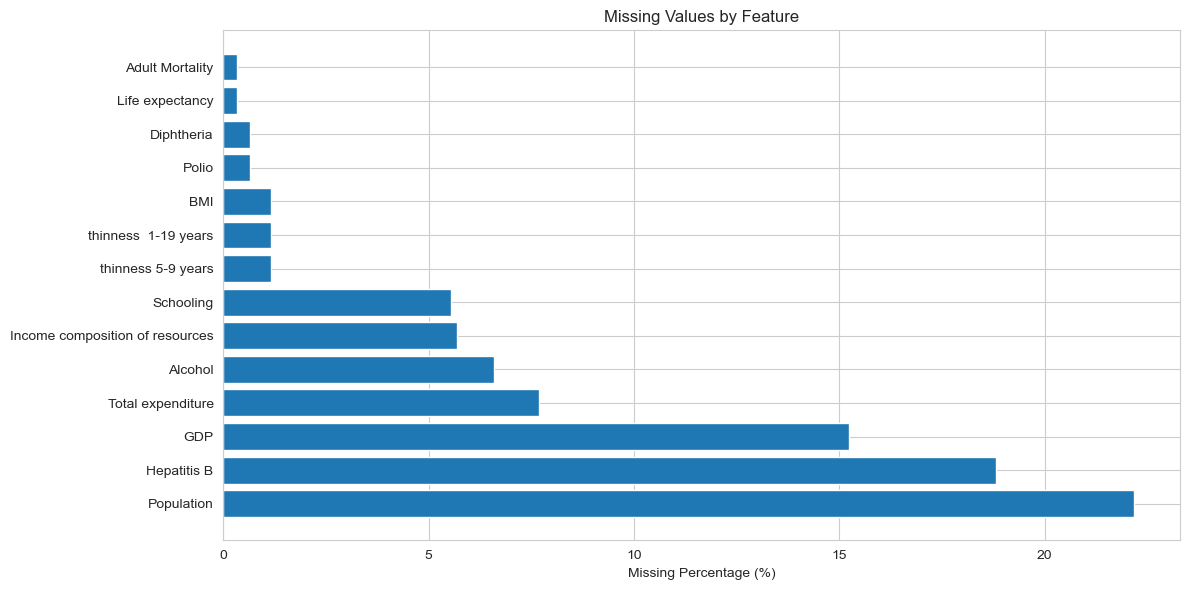

In [10]:
# Visualize missing values
if len(missing_data) > 0:
    plt.figure(figsize=(12, 6))
    plt.barh(missing_data['Column'], missing_data['Missing_Percentage'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Feature')
    plt.tight_layout()
    plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
# Check target variable (Life expectancy) missing values
target_missing = df['Life expectancy'].isnull().sum()
print(f"Target variable (Life expectancy) missing values: {target_missing}")
print(f"Percentage: {(target_missing / len(df) * 100):.2f}%")

Target variable (Life expectancy) missing values: 10
Percentage: 0.34%


## Cleaning Steps


In [12]:
# Create a copy for cleaning
df_clean = df.copy()

print(f"Starting with {len(df_clean)} observations")

Starting with 2938 observations


### Remove Missing Target


In [13]:
# Remove rows where target variable is missing
rows_before = len(df_clean)
df_clean = df_clean.dropna(subset=['Life expectancy'])
rows_removed = rows_before - len(df_clean)

print(f"Removed {rows_removed} rows with missing Life expectancy")
print(f"Remaining observations: {len(df_clean)}")

Removed 10 rows with missing Life expectancy
Remaining observations: 2928


### Missing Predictors


In [14]:
# NOTE: Imputation is deferred to model training to avoid leakage across time.
# We'll keep missing values here and fit imputers using training years only.

numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns with missing values: {(df_clean[numerical_cols].isnull().sum() > 0).sum()}")
print(f"Total missing values (all columns): {df_clean.isnull().sum().sum()}")


Numerical columns with missing values: 12
Total missing values (all columns): 2513


### Duplicates


In [15]:
# Check for duplicate rows based on Country and Year
duplicates = df_clean.duplicated(subset=['Country', 'Year'], keep=False)
print(f"Duplicate Country-Year pairs: {duplicates.sum()}")

if duplicates.sum() > 0:
    print("\nDuplicate entries:")
    print(df_clean[duplicates].sort_values(['Country', 'Year']))
    
    # Keep first occurrence and remove duplicates
    df_clean = df_clean.drop_duplicates(subset=['Country', 'Year'], keep='first')
    print(f"\nRemoved {duplicates.sum() - df_clean.duplicated(subset=['Country', 'Year']).sum()} duplicate rows")

print(f"\nFinal dataset size: {len(df_clean)} observations")

Duplicate Country-Year pairs: 0

Final dataset size: 2928 observations


### Target Outliers


In [16]:
# Detect outliers in life expectancy using IQR method
Q1 = df_clean['Life expectancy'].quantile(0.25)
Q3 = df_clean['Life expectancy'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # Using 3*IQR for more conservative outlier detection
upper_bound = Q3 + 3 * IQR

outliers = df_clean[(df_clean['Life expectancy'] < lower_bound) | 
                    (df_clean['Life expectancy'] > upper_bound)]

print(f"Life expectancy range: {df_clean['Life expectancy'].min():.1f} - {df_clean['Life expectancy'].max():.1f}")
print(f"Outlier bounds: {lower_bound:.1f} - {upper_bound:.1f}")
print(f"Number of outliers detected: {len(outliers)}")

if len(outliers) > 0:
    print("\nOutlier examples:")
    print(outliers[['Country', 'Year', 'Life expectancy', 'Status']].head(10))

Life expectancy range: 36.3 - 89.0
Outlier bounds: 25.3 - 113.5
Number of outliers detected: 0


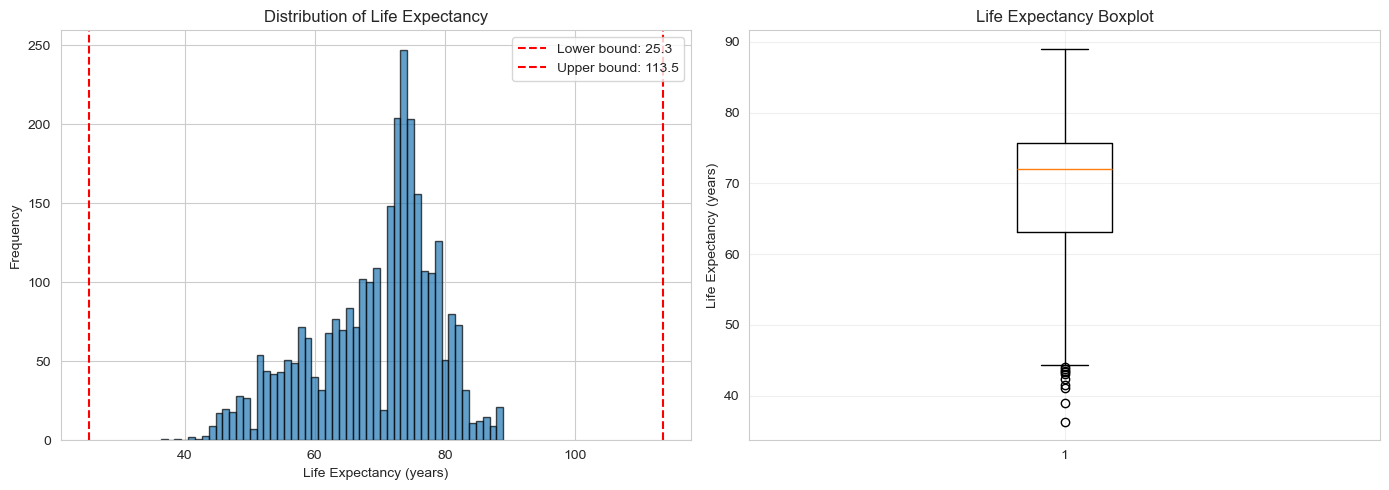

In [17]:
# Visualize target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['Life expectancy'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound: {lower_bound:.1f}')
axes[0].axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound: {upper_bound:.1f}')
axes[0].set_xlabel('Life Expectancy (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Life Expectancy')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_clean['Life expectancy'], vert=True)
axes[1].set_ylabel('Life Expectancy (years)')
axes[1].set_title('Life Expectancy Boxplot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/life_expectancy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Encode Status


In [18]:
# Encode Status as binary variable (Developed = 1, Developing = 0)
df_clean['Status_Encoded'] = (df_clean['Status'] == 'Developed').astype(int)

print("Status encoding:")
print(df_clean[['Status', 'Status_Encoded']].drop_duplicates())
print(f"\nDistribution:")
print(df_clean['Status'].value_counts())

Status encoding:
         Status  Status_Encoded
0    Developing               0
112   Developed               1

Distribution:
Status
Developing    2416
Developed      512
Name: count, dtype: int64


### Time Series Features


In [19]:
# IMPORTANT: Sort data by Country and Year for time series feature creation
print("Sorting data by Country and Year for time series features...")
df_clean = df_clean.sort_values(['Country', 'Year']).reset_index(drop=True)

print(f"\nDataset shape before time series features: {df_clean.shape}")
before_cols = df_clean.shape[1]

# 1. Create Years_Since_2000 (temporal feature)
df_clean['Years_Since_2000'] = df_clean['Year'] - 2000

# LAG FEATURES REMOVED - These caused data leakage
# See professor feedback from Week 4
# (Previously created Life_Expectancy_Lag_1/2/3, RollingMeans, and YoY change.)
print("Lag-based features removed to prevent data leakage (see Week 4 feedback).")

print(f"Dataset shape after time series features: {df_clean.shape}")
print(f"New features added: {df_clean.shape[1] - before_cols}")


Sorting data by Country and Year for time series features...

Dataset shape before time series features: (2928, 23)
Lag-based features removed to prevent data leakage (see Week 4 feedback).
Dataset shape after time series features: (2928, 24)
New features added: 1


### Missing Values from Lags


## EDA


### Target Analysis


In [20]:
# Summary statistics for life expectancy
print("Life Expectancy Statistics:")
print(df_clean['Life expectancy'].describe())

print(f"\nBy Development Status:")
print(df_clean.groupby('Status')['Life expectancy'].describe())

Life Expectancy Statistics:
count    2928.000000
mean       69.224932
std         9.523867
min        36.300000
25%        63.100000
50%        72.100000
75%        75.700000
max        89.000000
Name: Life expectancy, dtype: float64

By Development Status:
             count       mean       std   min   25%    50%   75%   max
Status                                                                
Developed    512.0  79.197852  3.930942  69.9  76.8  79.25  81.7  89.0
Developing  2416.0  67.111465  9.006092  36.3  61.1  69.00  74.0  89.0


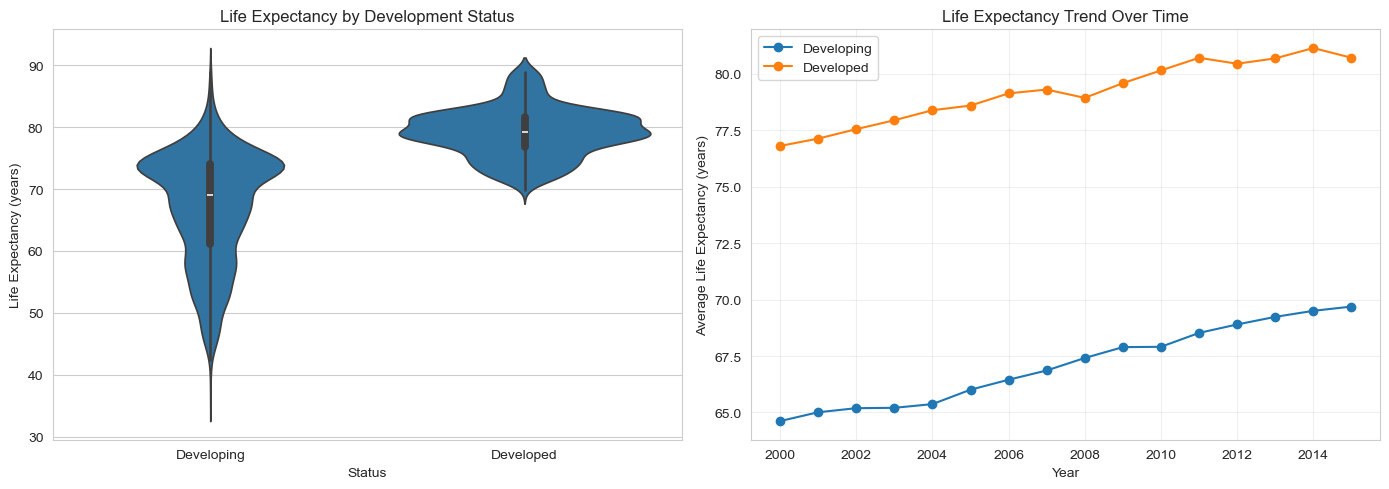

In [21]:
# Life expectancy by Status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violin plot
sns.violinplot(data=df_clean, x='Status', y='Life expectancy', ax=axes[0])
axes[0].set_title('Life Expectancy by Development Status')
axes[0].set_ylabel('Life Expectancy (years)')

# Trend over time
life_exp_trend = df_clean.groupby(['Year', 'Status'])['Life expectancy'].mean().reset_index()
for status in df_clean['Status'].unique():
    data = life_exp_trend[life_exp_trend['Status'] == status]
    axes[1].plot(data['Year'], data['Life expectancy'], marker='o', label=status)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Life Expectancy (years)')
axes[1].set_title('Life Expectancy Trend Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/life_expectancy_by_status.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlations


In [22]:
# Select numerical features for correlation analysis
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'Year']  # Exclude Year

# Calculate correlations with target
correlations = df_clean[numerical_features].corr()['Life expectancy'].sort_values(ascending=False)

print("Top 15 Features Correlated with Life Expectancy:")
print(correlations.head(15).to_string())

print("Bottom 10 Features (Negative Correlation):")
print(correlations.tail(10).to_string())

Top 15 Features Correlated with Life Expectancy:
Life expectancy                    1.000000
Schooling                          0.751975
Income composition of resources    0.724776
BMI                                0.567694
Status_Encoded                     0.482136
Diphtheria                         0.479495
Polio                              0.465556
GDP                                0.461455
Alcohol                            0.404877
percentage expenditure             0.381864
Hepatitis B                        0.256762
Total expenditure                  0.218086
Years_Since_2000                   0.170033
Population                        -0.021538
Measles                           -0.157586
Bottom 10 Features (Negative Correlation):
Total expenditure       0.218086
Years_Since_2000        0.170033
Population             -0.021538
Measles                -0.157586
infant deaths          -0.196557
under-five deaths      -0.222529
thinness 5-9 years     -0.471584
thinness  1-19 ye

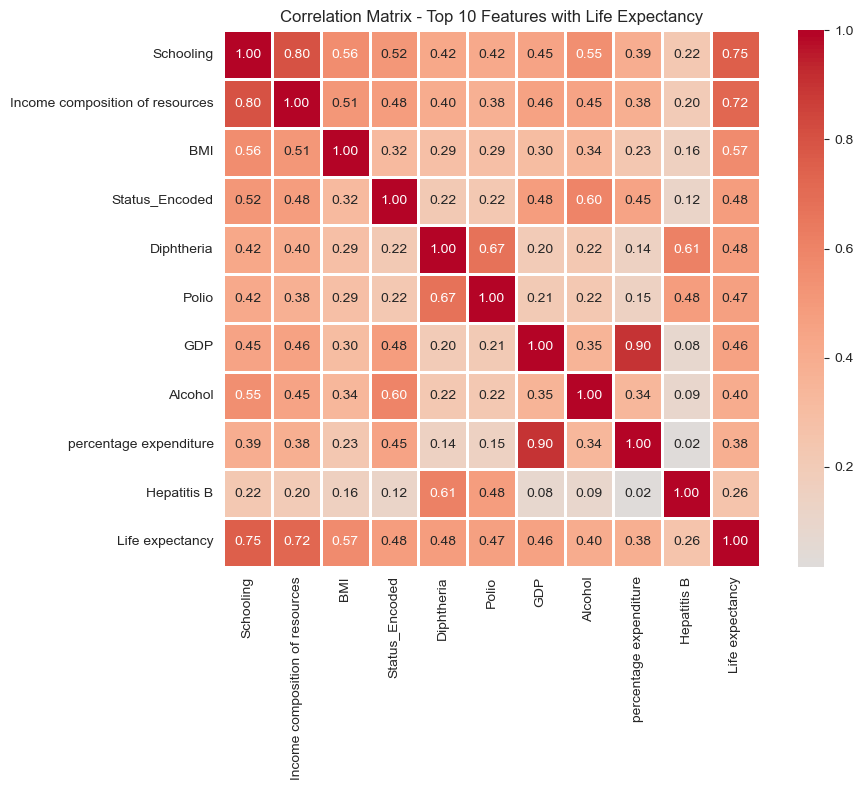

In [23]:
# Visualize top correlations
top_features = correlations.head(11).index.tolist()  # Top 10 + target itself
top_features.remove('Life expectancy')  # Remove target from list

plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[top_features + ['Life expectancy']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix - Top 10 Features with Life Expectancy')
plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/correlation_matrix_top10.png', dpi=300, bbox_inches='tight')
plt.show()

### Distributions


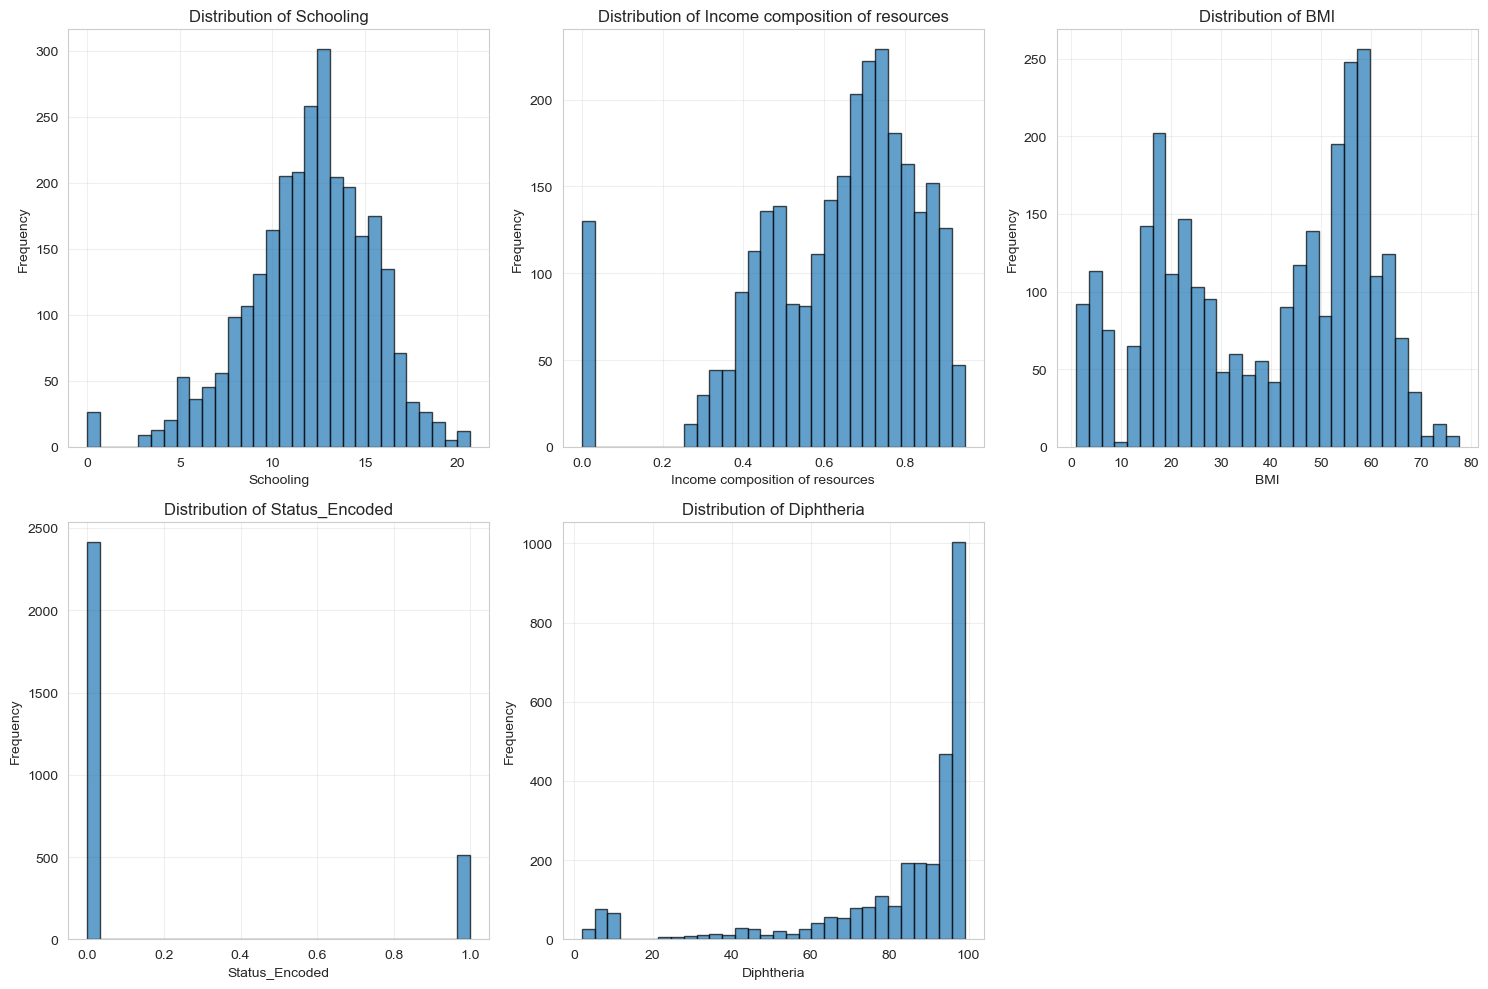

In [24]:
# Plot distributions of top features
top_5_features = correlations.head(6).index.tolist()
top_5_features.remove('Life expectancy')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_5_features):
    axes[idx].hist(df_clean[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].grid(True, alpha=0.3)

# Remove empty subplot
if len(top_5_features) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/top_features_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Scatter Plots


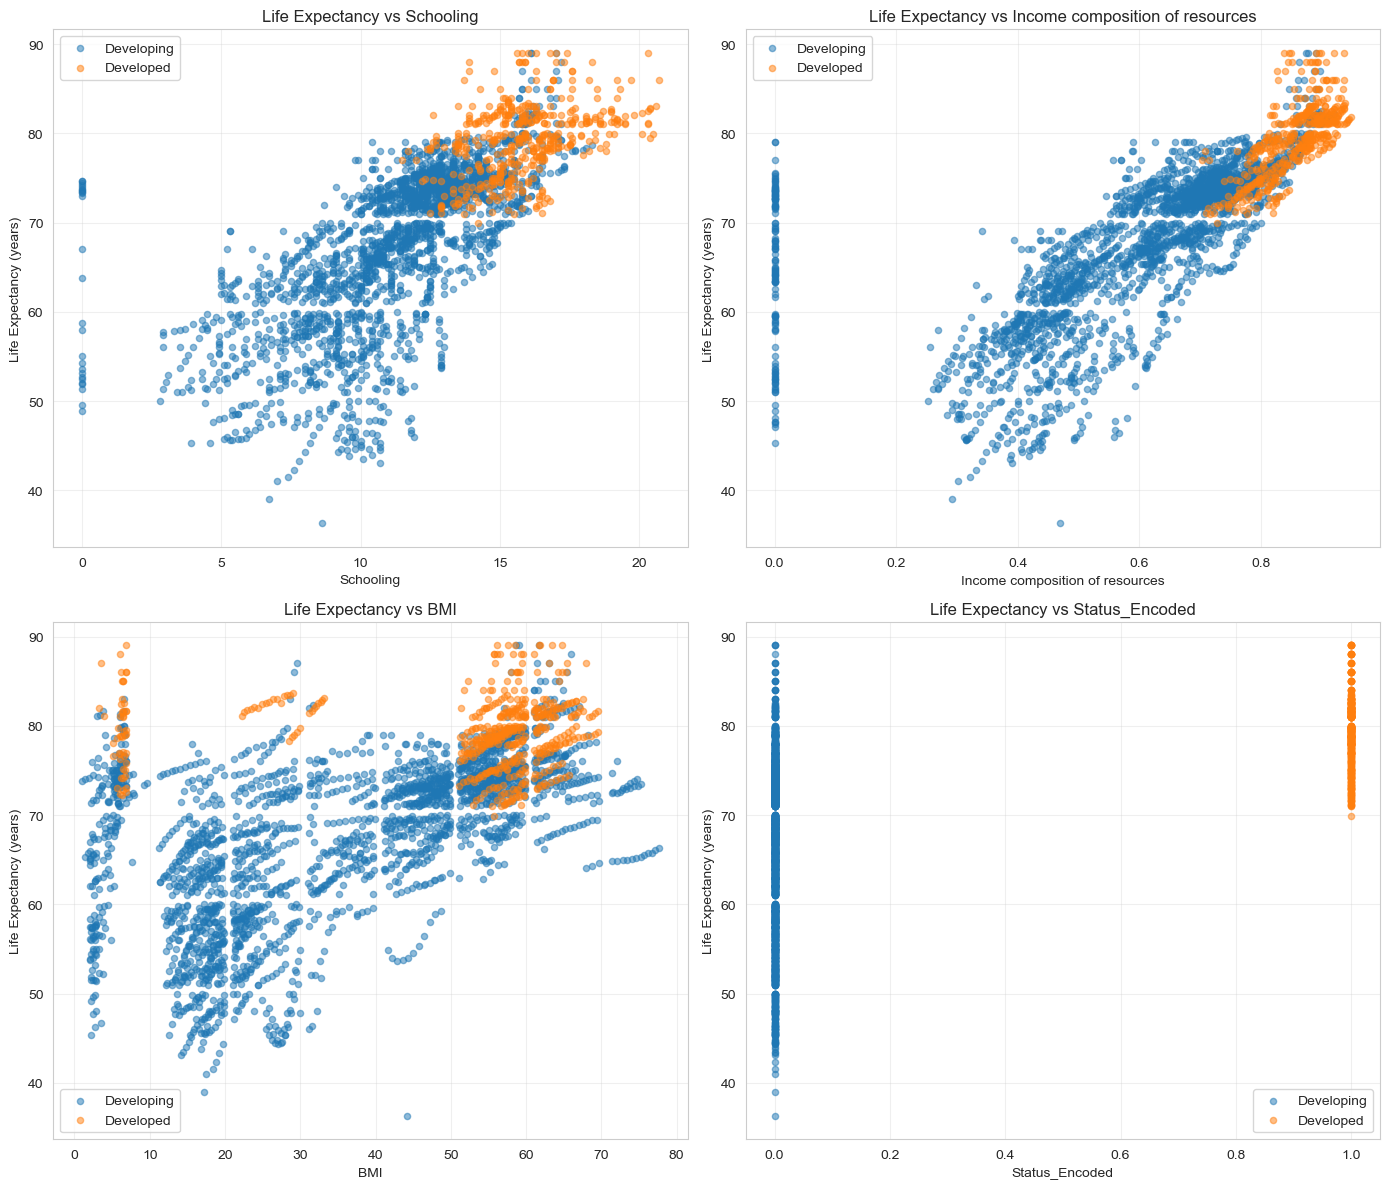

In [25]:
# Create scatter plots for most correlated features
top_4_positive = [col for col in correlations.head(5).index.tolist() if col != 'Life expectancy'][:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_4_positive):
    for status in df_clean['Status'].unique():
        data = df_clean[df_clean['Status'] == status]
        axes[idx].scatter(data[feature], data['Life expectancy'], 
                         alpha=0.5, label=status, s=20)
    
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Life Expectancy (years)')
    axes[idx].set_title(f'Life Expectancy vs {feature}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/scatter_plots_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

## Data Quality Summary


In [26]:
print("FINAL CLEANED DATASET SUMMARY")
print(f"Original dataset size: {df.shape[0]} observations, {df.shape[1]} features")
print(f"Cleaned dataset size: {df_clean.shape[0]} observations, {df_clean.shape[1]} features")
print(f"Observations removed: {df.shape[0] - df_clean.shape[0]} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.2f}%)")
print(f"\nMissing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicates: {df_clean.duplicated().sum()}")

print("DATASET CHARACTERISTICS:")
print(f"Countries: {df_clean['Country'].nunique()}")
print(f"Years covered: {df_clean['Year'].min()} - {df_clean['Year'].max()}")
print(f"Developed countries-year: {(df_clean['Status'] == 'Developed').sum()}")
print(f"Developing countries-year: {(df_clean['Status'] == 'Developing').sum()}")

print("TARGET VARIABLE (Life expectancy):")
print(f"Mean: {df_clean['Life expectancy'].mean():.2f} years")
print(f"Median: {df_clean['Life expectancy'].median():.2f} years")
print(f"Std Dev: {df_clean['Life expectancy'].std():.2f} years")
print(f"Range: {df_clean['Life expectancy'].min():.2f} - {df_clean['Life expectancy'].max():.2f} years")

print("FEATURE TYPES:")
print(f"Numerical features: {len(df_clean.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df_clean.select_dtypes(include=['object']).columns)}")

FINAL CLEANED DATASET SUMMARY
Original dataset size: 2938 observations, 22 features
Cleaned dataset size: 2928 observations, 24 features
Observations removed: 10 (0.34%)

Missing values: 2513
Duplicates: 0
DATASET CHARACTERISTICS:
Countries: 183
Years covered: 2000 - 2015
Developed countries-year: 512
Developing countries-year: 2416
TARGET VARIABLE (Life expectancy):
Mean: 69.22 years
Median: 72.10 years
Std Dev: 9.52 years
Range: 36.30 - 89.00 years
FEATURE TYPES:
Numerical features: 22
Categorical features: 2


## Final Dataset


In [27]:
# Create final dataset with selected features
# Keep Country and Year for reference but they won't be used in modeling

# List all columns
print("Columns in cleaned dataset:")
for idx, col in enumerate(df_clean.columns, 1):
    print(f"{idx:2d}. {col}")

# Verify data types
print("Data types:")
print(df_clean.dtypes)

Columns in cleaned dataset:
 1. Country
 2. Year
 3. Status
 4. Life expectancy
 5. Adult Mortality
 6. infant deaths
 7. Alcohol
 8. percentage expenditure
 9. Hepatitis B
10. Measles
11. BMI
12. under-five deaths
13. Polio
14. Total expenditure
15. Diphtheria
16. HIV/AIDS
17. GDP
18. Population
19. thinness  1-19 years
20. thinness 5-9 years
21. Income composition of resources
22. Schooling
23. Status_Encoded
24. Years_Since_2000
Data types:
Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
BMI                                float64
under-five deaths                    int64
Polio                              f

In [28]:
# Final check for data quality
print("Final Data Quality Checks:")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Duplicates: {df_clean.duplicated(subset=['Country', 'Year']).sum()}")
print(f"Negative values in non-negative features: ", end="")

# Check for negative values in features that should be non-negative
non_negative_cols = ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
                     'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
                     'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population',
                     'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources',
                     'Schooling']

negative_counts = 0
for col in non_negative_cols:
    if col in df_clean.columns:
        neg_count = (df_clean[col] < 0).sum()
        negative_counts += neg_count
        if neg_count > 0:
            print(f"\n  - {col}: {neg_count} negative values")

if negative_counts == 0:
    print("0")

print(f"\nDataset saved (imputation in modeling): {len(df_clean)} observations")

Final Data Quality Checks:
Missing values: 2513
Duplicates: 0
Negative values in non-negative features: 0

Dataset saved (imputation in modeling): 2928 observations


## Save Dataset


In [29]:
# Save cleaned dataset
output_file = '/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/clean_dataset.csv'

# Ensure lag features are not present (data leakage fix)
lag_features = [
    'Life_Expectancy_Lag_1',
    'Life_Expectancy_Lag_2',
    'Life_Expectancy_Lag_3',
    'Life_Expectancy_RollingMean_3yr',
    'Life_Expectancy_RollingMean_5yr',
    'Life_Expectancy_YoY_Change',
]

before_cols = df_clean.shape[1]
present_lags = [c for c in lag_features if c in df_clean.columns]
if present_lags:
    print(f"Removing lag features (data leakage): {present_lags}")
    df_clean = df_clean.drop(columns=present_lags)

after_cols = df_clean.shape[1]
print(f"Column count before lag check: {before_cols}")
print(f"Column count after lag check: {after_cols}")
print(f"Lag features present after check: {[c for c in lag_features if c in df_clean.columns]}")
if after_cols != 24:
    print(f"WARNING: Expected 24 columns, got {after_cols}")

df_clean.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to: {output_file}")
print(f"Shape: {df_clean.shape}")
print(f"\nDataset is ready for Week 3: Baseline Models & Evaluation")


Column count before lag check: 24
Column count after lag check: 24
Lag features present after check: []
Cleaned dataset saved to: /Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/clean_dataset.csv
Shape: (2928, 24)

Dataset is ready for Week 3: Baseline Models & Evaluation
